# OpenAI - Caribbean Challenge Competition 

### Train an Image Classifier from Aerial Photos with Transfer learning 

### UNET  architecture by zf



see: /https://github.com/ZFTurbo?utf8=%E2%9C%93&tab=repositories&q=&type=&language=python



##### Run: 1.0


- Freeze UNET weights

- Add dropout at head -- try with Avg Pooling head

- add RAdam optimizer

In [2]:
import numpy as np
import pandas as pd
import os
import gc

from tqdm import tqdm_notebook as tqdm

from pathlib import Path
import cv2

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# from helpers import plot_confusion_matrix, eval_metrics, plot_conv_weights
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

In [3]:
# TF Keras imports
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D, GlobalAveragePooling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import *
from keras.activations import *
from keras.layers import *
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.utils import Sequence
from keras.utils import to_categorical

# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers.core import SpatialDropout2D, Activation
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers.merge import concatenate

Using TensorFlow backend.


In [4]:
from keras import backend as K

config = tf.ConfigProto()
config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1
sess = tf.Session(config=config)

In [5]:
from rectified_adam import RectifiedAdam

# optm = RectifiedAdam(lr=1e-3)

In [ ]:
# from zf_unet_224_model import ZF_UNET_224, dice_coef_loss, dice_coef

# ZF_UNET_224(weights='generator').summary()

# optim = keras.optimizers.Adam()
# model.compile(optimizer=optim, loss=dice_coef_loss, metrics=[dice_coef])

In [6]:
def preprocess_input(x):
    x /= 256
    x -= 0.5
    return x


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

In [ ]:
# def double_conv_layer(x, size, dropout=0.0, batch_norm=True):
# #     if K.image_dim_ordering() == 'th':
# #         axis = 1
# #     else:
# #         axis = 3
#     axis=3
#     conv = Conv2D(size, (3, 3), padding='same')(x)
#     if batch_norm is True:
#         conv = BatchNormalization(axis=axis)(conv)
#     conv = Activation('relu')(conv)
#     conv = tf.keras.layers.Conv2D(size, (3, 3), padding='same')(conv)
#     if batch_norm is True:
#         conv = tf.keras.layers.normalization.BatchNormalization(axis=axis)(conv)
#     conv = tf.keras.layers.core.Activation('relu')(conv)
#     if dropout > 0:
#         conv = SpatialDropout2D(dropout)(conv)
#     return conv

### Load image data

In [7]:
curr_path = Path('/home/ime/Documents/PycharmProjects/DrivenData/OpenAI')
data_path = curr_path / 'data/raw'
train_path = curr_path / 'data/pickle/'
img_path = curr_path / 'data/processed2/trainImages/'

categories = ['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [8]:
# Load all image file names
fnames = []
for categ in categories:
    sub_folder = os.path.join(img_path, categ)
    file_names = os.listdir(sub_folder)
    full_path = [os.path.join(sub_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [9]:
print('length of each class:', [len(f) for f in fnames])
print('total number of images:', sum([len(f) for f in fnames]))

length of each class: [1387, 7381, 668, 5241, 193]
total number of images: 14870


### Load images

In [10]:
images = []
for names in fnames:
    one_class_img = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_class_img)

In [11]:
del one_class_img
gc.collect()

# # Load images with keras
images2 = []
for names in fnames:
    one_class_img = [image.load_img(name) for name in names if (image.load_img(name)) is not None]
    images2.append(one_class_img)

In [11]:
print('no. of images for each class:', [len(f) for f in images])
# print('no. of images for each class:', [len(f) for f in images2])

no. of images for each class: [1387, 7381, 668, 5241, 193]


In [ ]:
# compare cv2 with keras image
images[0][1].shape, image.img_to_array(images2[0][1]).shape

### Calculate minimal shape for all images

49, 67 is the min shape for concrete_cement

1199, 1186 is the max shape for concrete_cement
----------
14, 1 is the min shape for healthy_metal

1856, 1488 is the max shape for healthy_metal
----------
49, 51 is the min shape for incomplete

448, 438 is the max shape for incomplete
----------
42, 47 is the min shape for irregular_metal

856, 723 is the max shape for irregular_metal
----------
60, 37 is the min shape for other

664, 708 is the max shape for other
----------


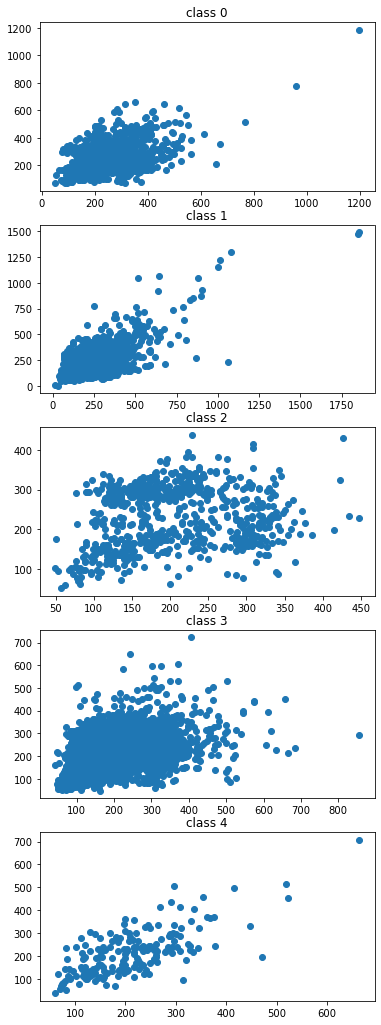

In [12]:
fig, ax = plt.subplots(5,1, figsize=(6, 18))
for i, imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d, %d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))    
    print()
    print('%d, %d is the max shape for %s' % (np.max(widths), np.max(heights), categories[i]))    
    print('-'*10)
    ax[i].scatter(widths, heights, label=('class %s' % i))
    ax[i].set_title(('class %s' % i))
    

### Show sample of images for all classes

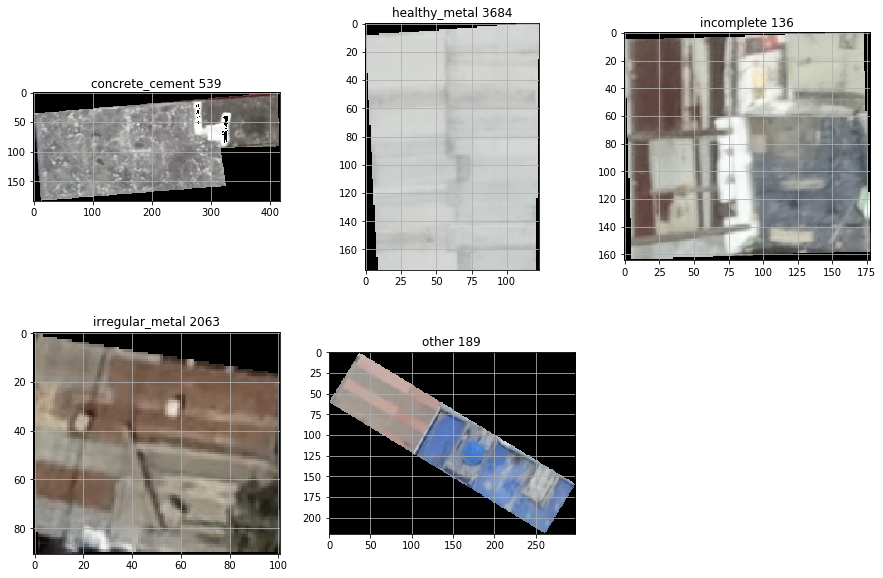

In [11]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2, 3, i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(imgs[idx])
    plt.grid('off')
    plt.title(categories[i]+' '+str(idx))
plt.show()

### Resize all images

In [12]:
IMG_SIZE = 224
NO_CHANNELS = 3

In [13]:
# apply to all images
images_resized = []
for i, imgs in enumerate(images):
    images_resized.append([cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC) for img in imgs])

before: (278, 182, 3)
after: (224, 224, 3)


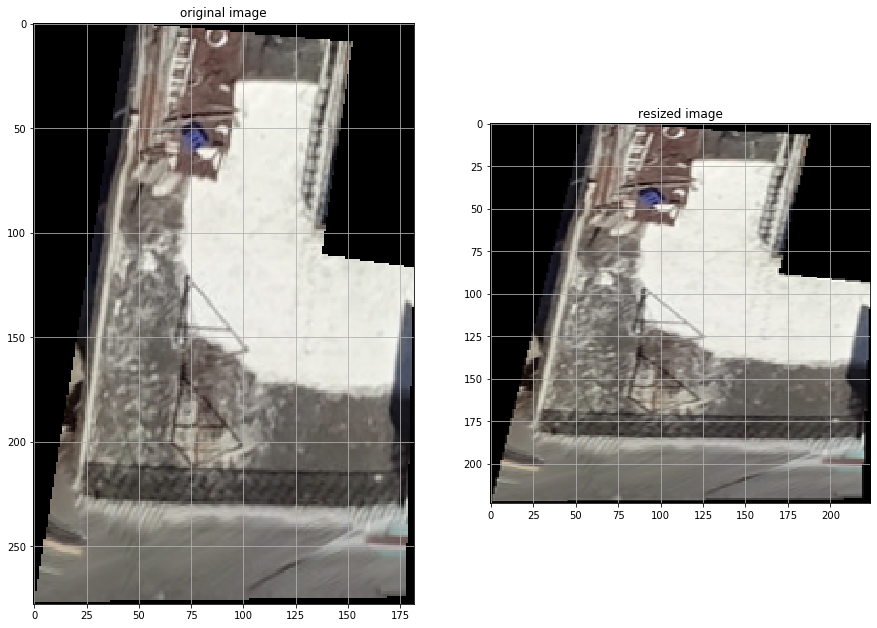

In [15]:
rand_idx = np.random.randint(0,1387)

print('before:', images[0][rand_idx].shape)
print('after:', images_resized[0][rand_idx].shape)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('original image')
plt.grid('False')
plt.imshow(images[0][rand_idx])
plt.subplot(1,2,2)
plt.title('resized image')
plt.grid('False')
plt.imshow(images_resized[0][rand_idx])
plt.show()

In [16]:
del images
gc.collect()

5264

### Download 

In [ ]:
# # download label data

# with open(train_path/'train_labels.pickle', 'rb') as f:
#     train_labels_original  = pickle.load(f)

# with open(train_path/'Y_train_verified.pickle', 'rb') as f:
#     Y_train = pickle.load(f)

# Y_train = [item for sublist in Y_train for item in sublist]
# le = LabelEncoder()
# Y_dummy_original = tf.keras.utils.to_categorical(le.fit_transform(Y_train), num_classes=5)

# Y_dummy_original

### Histograms

Category 0


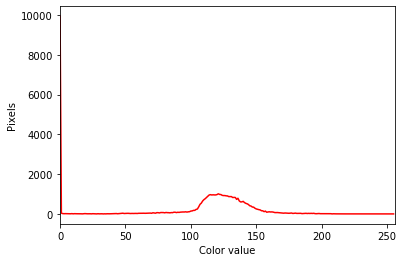

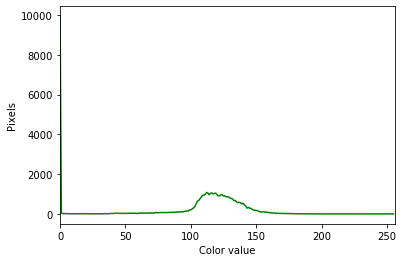

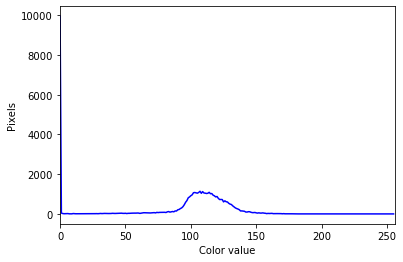

Category 1


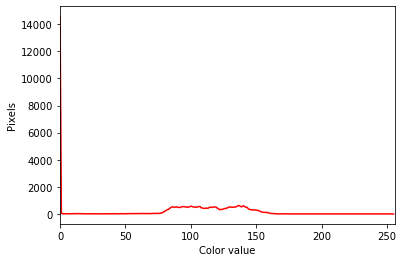

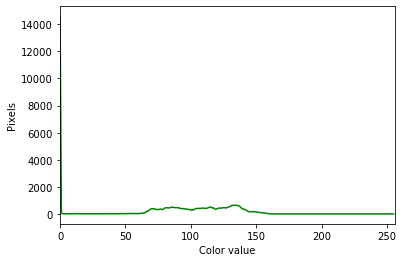

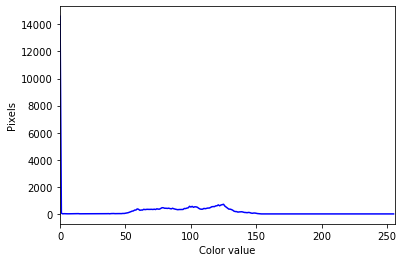

Category 2


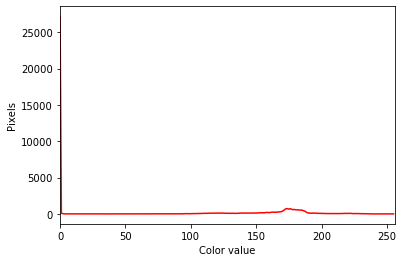

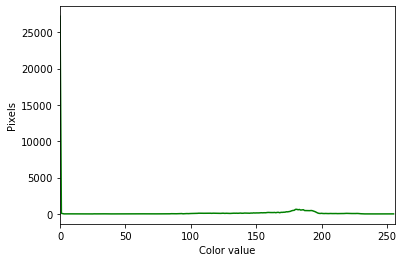

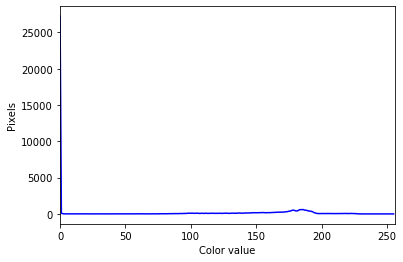

Category 3


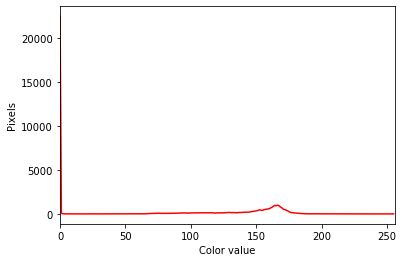

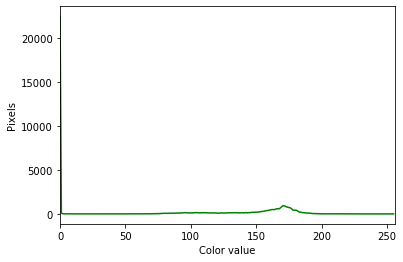

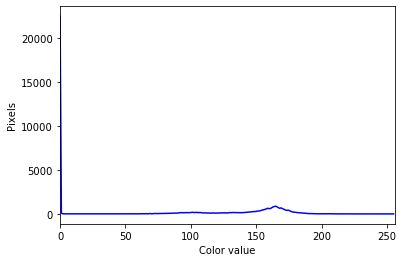

In [15]:
# import skimage.io

# tuple to select colors of each channel line
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

# read 1 resized image from each class (0-4)
   # 
for categ in range(4):
    rand_idx = np.random.randint(len(categories[categ]))
    tmp_image = images_resized[categ][rand_idx]
    # display the image
#     plt.imshow(tmp_image)

#     #split into channels
#     # img_channels = [tmp_image[:, :, i] for i in range(3)]
    print('Category', categ)
    for channel_id, c in zip(channel_ids, colors):
        hist, bin_edges = np.histogram(tmp_image[:, :, channel_id], bins=256, range=(0, 256))
        plt.plot(bin_edges[0:-1], hist, color=c)
        plt.xlabel("Color value")
        plt.ylabel("Pixels")
        plt.xlim([0, 256])
        plt.show()
    
#     break;    # remove to cont.

### Split to train/val sets

In [14]:
train_images = []
val_images = []
train_y = []
val_y = []
for imgs in images_resized:
    train, val = train_test_split(imgs, test_size=0.25)
    train_images.append(train)
    val_images.append(val)

### Create labels from scratch

In [15]:
# A) kernel approach
len_train_images= [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images: ', np.sum(len_train_images))
train_categories = np.zeros(np.sum(len_train_images), dtype='uint8')
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i

len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val images: ', np.sum(len_val_images))
val_categories = np.zeros(np.sum(len_val_images), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[1040, 5535, 501, 3930, 144]
sum of train images:  11150
[347, 1846, 167, 1311, 49]
sum of val images:  3720


### Convert images to arrays

In [16]:
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)    
val_images = np.array(tmp_val_imgs)

In [17]:
del tmp_train_imgs, tmp_val_imgs
gc.collect()

47

In [ ]:
# with Keras image

# tmp_train = []
# tmp_val = []
# for imgs in train_images:
#     tmp_trainn = image.img_to_array(imgs)
#     train_images2.append(tmp_train)


In [18]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)
# print('train labels2:', train_y.shape)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')

train_labels = keras.utils.to_categorical(train_categories, len(categories))
val_labels = keras.utils.to_categorical(val_categories, len(categories))

print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)
# print('train labels2:', train_y.shape)

Before converting
train data: (11150, 224, 224, 3)
train labels: (11150,)

After converting
train data: (11150, 224, 224, 3)
train labels: (11150, 5)


In [51]:
# # save img arrays to disk before shuffling
# import pickle

# # with open('./data/pickle/X_train_data_02.pickle', 'wb') as file:
# #     pickle.dump(train_data, file)
    
# # with open('./data/pickle/Y_train_data_02.pickle', 'wb') as file:
# #     pickle.dump(train_labels, file)
    
# # with open('./data/pickle/X_valid_data_02.pickle', 'wb') as file:
# #     pickle.dump(val_data, file)
    
# # with open('./data/pickle/Y_valid_data_02.pickle', 'wb') as file:
# #     pickle.dump(val_labels, file)

# train_data[0].flatten().shape

(150528,)

### Shuffle dataset (both features and labels using same seed)

In [19]:
SEED = 10
np.random.seed(SEED)
np.random.shuffle(train_data)

np.random.seed(SEED)
np.random.shuffle(train_labels)

np.random.seed(SEED)
np.random.shuffle(val_data)

np.random.seed(SEED)
np.random.shuffle(val_labels)

healthy_metal 1


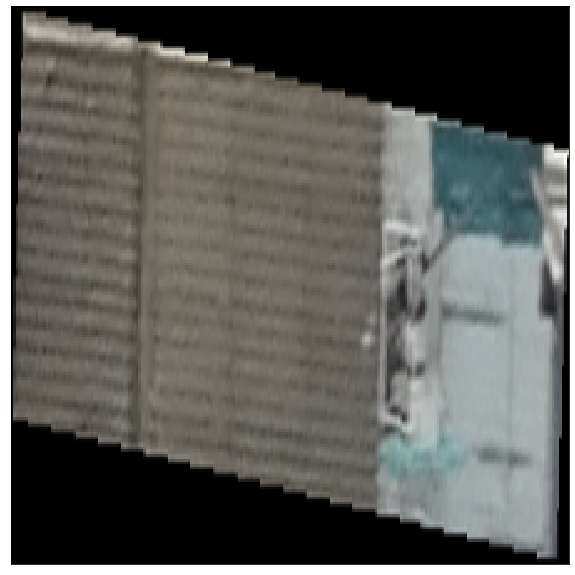

In [20]:
# TODO: check shuffled data    

# train_data
idx = np.random.randint(len(train_data))

plt.figure(figsize=(10,20))
plt.imshow(image.array_to_img(train_data[idx]))    
print(categories[np.argmax(train_labels[idx])], np.argmax(train_labels[idx]))
plt.grid(False)
plt.yticks([])
plt.xticks([])
plt.show()

### Master params

In [21]:
BATCH_SIZE = 128
EPOCHS = 200

no_classes = 5

In [ ]:
# # Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
# INPUT_CHANNELS = 3
# # Number of output masks (1 in case you predict only one type of objects)
# OUTPUT_MASK_CHANNELS = 1

# Pretrained UNET weights
# ZF_UNET_224_WEIGHT_PATH = 'https://github.com/ZFTurbo/ZF_UNET_224_Pretrained_Model/releases/download/v1.0/zf_unet_224.h5'

# str(ZF_UNET_224_WEIGHT_PATH).endswith('.h5')

### Build Model

#see: 


In [22]:
K.clear_session()

In [23]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal", padding="same")(input_tensor)
    if batchnorm: x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal", padding="same")(x)
    if batchnorm: x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [24]:
def build_unet(img_size, n_filters=16, dropout=0.5, batchnorm=True):
    inp = Input((img_size, img_size, 3), name='inp')
    # contracting path
    c1 = conv2d_block(inp, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    #  head = GlobalAveragePooling2D()(c9)
    head = Flatten()(c9)
    head = Dense(units=512, activation='relu')(head)
    head = Dropout(0.5)(head)
    out = Dense(units=5, activation='softmax')(head)
    
    model = Model(inputs=[inp], outputs=[out])
    return model
    
    # For mask
    #     outputs = Conv2D(5, (1, 1), activation='sigmoid') (c9)

In [25]:
model = build_unet(IMG_SIZE, n_filters=16, dropout=0.2, batchnorm=True)    # weights='generator'

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp (InputLayer)                (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 448         inp[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activat

In [ ]:
# split = 142   # 105, 125, 128, 132, 142

# for layer in model.layers[:split]:
#     layer.trainable = False
     
# for layer in model.layers[split:]:
#     layer.trainable = True    

In [ ]:
# pd.set_option('display.max_rows', None)

# #check trainable layers
# layers_df = pd.DataFrame([(layer, layer.name, layer.trainable) for layer in model.layers], 
#                          columns=['Layer Type', 'Layer Name', 'Trainable'])

# layers_df

#### Compile Model

In [26]:
# compile the final model after freezing weights    

# optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
# optimizers.RMSprop(lr=2e-5)
# optimizers.Adam(lr=0.0001)
    
model.compile(loss='categorical_crossentropy',       
              optimizer=RectifiedAdam(lr=1e-3),                    
              metrics=['accuracy', dice_coef]) 

# model.compile(loss='categorical_crossentropy', 
#               optimizer=SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),                    
#               metrics=['acc']) 

### Create Generators

In [28]:
# train configuration: rescale, rotation, shift, shear/zoom range, horizontal flip
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# validation configuration: rescale only
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow images 
train_generator = train_datagen.flow(train_data, train_labels, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(val_data, val_labels, batch_size=BATCH_SIZE)

In [29]:
# # callbacks 
# from keras.callbacks import EarlyStopping
# from keras.callbacks import ReduceLROnPlateau
# from keras.callbacks import ModelCheckpoint
# from keras.callbacks import TensorBoard
# # from tf.keras.callbacks

mdl_dir = '/home/ime/Documents/PycharmProjects/DrivenData/OpenAI/saved_models/model2/'
mdl_name = 'Unet_train_all_Radam_run1.h5'       


es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min') 
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, )  # min_delta=0.0001
mc = ModelCheckpoint(filepath=mdl_dir+mdl_name, monitor='val_loss', save_best_only=True, mode='auto')
# tb = TensorBoard(log_dir=tb_dir, write_graph=True, update_freq='epoch')

callback_list=[es, rlr, mc]

In [30]:
# class weights
from sklearn.utils.class_weight import compute_class_weight

classWeight = compute_class_weight('balanced', np.unique([0,1,2,3,4]), train_categories) 
classWeight = dict(enumerate(classWeight))

classWeight

{0: 2.144230769230769,
 1: 0.4028906955736224,
 2: 4.4510978043912175,
 3: 0.5674300254452926,
 4: 15.48611111111111}

### Show generated augmented images

In [ ]:
img_id = 6700

# 1208 -- class 0
# 1205 -- class 1
# 2500, 1200 -- class 3           

img_generated = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1], batch_size=1) 
img_gen = [next(img_generated) for i in range(0,5)] 

fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [np.argmax(item[1][0]) for item in img_gen]) 
l = [ax[i].imshow(img_gen[i][0][0]) for i in range(0,5)]

## Train the model


#### Fit the model with generator

In [ ]:
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())

In [31]:
print('Training: ' + mdl_name)

hist = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=np.ceil(len(train_data)/BATCH_SIZE),     # 349 step*BATCH_SIZE = num of images
    epochs=EPOCHS,
    validation_steps=np.ceil(len(val_data)/BATCH_SIZE),        # 117 step*BATCH_SIZE = num of images
    validation_data=val_generator,
    verbose=1,
    callbacks=callback_list,
    class_weight=classWeight,
)

Training: Unet_train_all_Radam_run1.h5
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
88/88 [==============================] - 2409s 27s/step - loss: 4.8862 - acc: 0.1223 - dice_coef: 0.1992 - val_loss: 1.6097 - val_acc: 0.0454 - val_dice_coef: 0.2032
Epoch 2/200
88/88 [==============================] - 2391s 27s/step - loss: 1.6125 - acc: 0.0447 - dice_coef: 0.2035 - val_loss: 1.6106 - val_acc: 0.0465 - val_dice_coef: 0.2030
Epoch 3/200
88/88 [==============================] - 2368s 27s/step - loss: 1.6026 - acc: 0.0445 - dice_coef: 0.2035 - val_loss: 1.6087 - val_acc: 0.0454 - val_dice_coef: 0.2033
Epoch 4/200
50/88 [================>.............] - ETA: 16:00 - loss: 1.6028 - acc: 0.4092 - dice_coef: 0.2034

KeyboardInterrupt: 

In [ ]:
# Fit without generator

train_data2 = train_data/255.
val_data2 = val_data/255.

hist2 = model.fit(train_data2, train_labels, 
                  batch_size=BATCH_SIZE, 
                 epochs=EPOCHS,
                 validation_data=(val_data2, val_labels),
                 callbacks=callback_list,
                 class_weight=classWeight,
                 shuffle=True)


### Evaluate the model

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'g')
plt.xticks()
plt.title('loss')
plt.legend(['train', 'val'], loc='best')    

plt.subplot(1,2,2)
plt.plot(hist.history['acc'], 'r')
plt.plot(hist.history['val_acc'], 'g')
plt.xticks()
plt.title('accuracy')
plt.legend(['train', 'val'], loc='best')            
plt.show()                

### Predict one Image

In [ ]:
def predict_one_image(img, model=model):
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_CUBIC)
    img = np.reshape(img, (1, IMG_SIZE, IMG_SIZE, 3))
    img = img/255.
    pred = model.predict(img)
    pred_class = np.argmax(pred)
    return pred_class, np.max(pred)    

In [ ]:
sample_img = cv2.imread(test_fnames[23])

pred, prob = predict_one_image(sample_img, model)
print('%s %d%%' % (categories[pred], round(prob,2)*100))
_, ax = plt.subplots(1)
plt.imshow(sample_img)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()

del pred, prob
gc.collect()

### Predict on validation data

In [ ]:
def predict_val_data(val_data, model=model):
    """
    Returns: pred (,5)
             pred_class [0-4]
             pred_prob [0. - 1.]
    """
    val_input = np.reshape(val_data, (-1, IMG_SIZE, IMG_SIZE, 3))
    val_input = val_input/255.
    pred = model.predict(val_input)
    pred_class = np.argmax(pred)
    return pred, pred_class, np.max(pred)  


In [ ]:
def return_categ_name(label_arr):
    idx = np.where(label_arr == 1)
    return idx[0][0]

In [ ]:
plt.figure(figsize=(10,20))
for i in range(10):
    idx = np.random.randint(len(val_data))

    ax = plt.subplot(5, 2, i+1)
    plt.imshow(val_data.astype('uint8')[idx])
    category_idx = return_categ_name(val_labels[idx])

    _, pred_class, pred_prob = predict_val_data(val_data[idx], model=model)
    
    plt.title('True: %s | Pred: %s %d%%' % (categories[category_idx], categories[pred_class], round(pred_prob, 2)*100))
    plt.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.show()

In [ ]:
y_pred_val, y_pred_class_val, _ =  predict_val_data2(val_data)

In [ ]:
# # Logloss score
# score_logloss = log_loss(val_data, np.argmax(y_pred_val))
# print('Score on val data:', score_logloss)
# np.argmax(y_pred_val)
# y_pred_val[0]
# val_data[0]

In [ ]:
# # save model (optional)
# model.save('Resnet50-1024-512_loss_xxx.h5')

In [ ]:
# check missclassied images

def show_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of mislabeled images by the classifier:", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(mislabeled_images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[mislabeled_labels[i]])
    plt.show()


In [ ]:
# predictions = model.predict(val_data)
# pred_labels = np.argmax(predictions, axis = 1)

print_mislabeled_images(categories, val_data, val_labels, np.argmax(y_pred_val, axis = 1))

### Predict on Test Images

#### Load test images filenames

In [ ]:
PREDICT_WITH_GEN = True

In [ ]:
test_fnames = []
test_file_names = os.listdir(curr_path / 'data/processed2/testImages/')
test_fnames = [os.path.join(curr_path / 'data/processed2/testImages/', file_name) for file_name in test_file_names]

In [ ]:
test_fnames[:1], test_file_names[:1]

In [ ]:
# load test Images with CV2
testImages = [cv2.imread(name) for name in test_fnames if (cv2.imread(name)) is not None]

# load test Images with Keras
testImages2 = [image.img_to_array(name) for name in test_fnames if (image.img_to_array(name)) is not None]

len(testImages, testImages2)

In [ ]:
# check original sizes of test Images 
test_shapes = [img.shape for img in testImages]
test_widths= [shape[0] for shape in test_shapes]
test_heights = [shape[1] for shape in test_shapes]
print('%d, %d is the min shape for test set' % (np.min(test_widths), np.min(test_heights)))    
print('-'*40)
print('%d, %d is the max shape for test set' % (np.max(test_widths), np.max(test_heights))) 

#### Resize test images

In [ ]:
# check size before 
print('size before:', testImages[10].shape)

# resize test images
test_images_resized = []
test_images_resized = [cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC) for img in testImages]

# check size after
print('size after:', test_images_resized[10].shape)
print()
print('number of test images:', len(test_images_resized) )

In [ ]:
# rescale 
if PREDICT_WITH_GEN = False:
    test_images_resized = np.array(test_images_resized)/255.

# reshape to 4D
test_images_resized = np.array(test_images_resized).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# check new shape
test_images_resized[0].shape

In [ ]:
del testImages
gc.collect()

### Inference on Test images with generator

In [ ]:
# Augmentation config for Test Images

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(test_images_resized, batch_size=1)

test_preds_gen = model.predict_generator(test_generator, verbose=1)

### Inference on Test Images without generator

In [ ]:
# #test predictions without generator
# test_preds = model.predict(test_images_resized, batch_size=1)

# test_preds_class = np.argmax(test_preds, axis=1)
# test_preds_class2 = [categories[test_preds_class[i]] for i in range(len(test_preds))] 

### Submission file

In [ ]:
mdl_name = 'Unet-headPool'
out_name = 'Submission_'
out_name += mdl_name
out_name += '_epochs1'

sub_df = pd.read_csv(data_path/'submission_format.csv')
sub_df.head()

In [ ]:
test_preds_class = np.argmax(test_preds_gen, axis=1)

# sub_df.iloc[:, 1:] = np.array(test_preds_class)

In [ ]:
# export to csv 
# sub_df.to_csv('%s.csv' % out_name, index=None)

In [ ]:
# sub_df.head()

### Fine-tune Transfer learning ResNet-50 

In [ ]:
# # fine tune ResNet-50 + Dense

# resnet.trainable = True
# set_trainable = False
# for layer in resnet.layers:
#     if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False
        
# # print df        
# layers_df = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
# layers_df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

# layers_df